In my last [post]({filename}/2015-11-02-intro-to-collaborative-filtering.md), I described user- and item-based collaborative filtering which are some of the simplest recommendation algorithms. For someone who is used to conventional machine learning classification and regression algorithms, collaborative filtering may have felt a bit *off*. To me, machine learning almost always deals with some function which we are trying to maximize or minimize. In simple linear regression, we minimize the mean squared distance between our predictions and the true values. Logistic regression involves maximizing a likelihood function. However, in my post on collaborative filtering, we randomly tried a bunch of different parameters (distance function, top-k cutoff) and watched what happened to the mean squared error. This sure doesn't feel like machine *learning*. 

To bring some technical rigor to recommender systems, I would like to talk about matrix factorization where we do, in fact, *learn* parameters to a model in order to directly minimize a function. Explanations of matrix factorization often start with talks of "low-rank matrices" and "singular value decomposition". While these are important for a fundamental understanding of this topic, I don't find math-speak to be too helpful in understanding the basic concepts of various algorithms. Let me simply state the assumptions that basic matrix factorization makes. 

## Initial assumptions

We will use the same example data from the previous post, so recall that we had a user-by-item matrix where nonzero elements of the matrix are ratings that a user has given an item. Matrix factorization *assumes* that:

- Each user can be described by *k* *attributes* or *features*. For example, feature 1 might be a number that says how much each user likes sci-fi movies.
- Each item (movie) can be described by an analagous set of *k* attributes or features. To correspond to the above example, feature 1 for the movie might be a number that says how close the movie is to pure sci-fi.
- If we multiply each feature of the user by the corresponding feature of the movie and add everything together, this will be a good approximation for the rating the user would give that movie.

That's it. The beauty is that we do not know what these features are. Nor do we know how many (*k*) features are relevant. We simply pick a number for *k* and learn the relevant values for all the features for all the users and items. How do we learn? By minimizing a loss function, of course!

We can turn our matrix factorization approximation of a *k*-attribute user into math by letting a user *u* take the form of a *k*-dimensional vector $\textbf{x}_{u}$. Similarly, an item *i* can be represented by a *k*-dimensional vector $\textbf{y}_{i}$. User *u*'s predicted rating for item *i* is just the dot product of their two vectors

$$\hat r_{ui} = \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i} = \sum\limits_{k} x_{uk}y_{ki}$$

where $\hat r_{ui}$ represents our prediction for the true rating $r_{ui}$, and $\textbf{y}_{i}$ ($\textbf{x}_{u}^{\intercal}$) is assumed to be a column (row) vector. These user and item vectors are often called latent vectors or low-dimensional embeddings in the literature. The *k* attributes are often called the latent factors. We will choose to minimize the square of the difference between all ratings in our dataset ($S$) and our predictions. This produces a loss function of the form

$$L = \sum\limits_{u,i \in S}(r_{ui} - \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i})^{2} + \lambda_{x} \sum\limits_{u} \left\Vert \textbf{x}_{u} \right\Vert^{2} + \lambda_{y} \sum\limits_{u} \left\Vert \textbf{y}_{i} \right\Vert^{2}$$

Note that we've added on two $L_{2}$ regularization terms at the end to prevent overfitting of the user and item vectors. Our goal now is to minimize this loss function. Derivatives are an obvious tool for minimizing functions, so I'll cover the two most popular derivative-based methods. We'll start with Alternating Least Squares (ALS).

## Alternating Least Squares

For ALS minimiztion, we hold one set of latent vectors constant. For this example, we'll pick the item vectors. We then take the derivative of the loss function with respect to the other set of vectors (the user vectors). We set the derivative equal to zero (we're searching for a minimum) and solve for the non-constant vectors (the user vectors). Now comes the alternating part: With these new, solved-for user vectors in hand, we hold *them* constant, instead, and take the derivative of the loss function with respect to the previously constant vectors (the item vectors). We alternate back and forth and carry out this two-step dance until convergence.

### Derivation

To explain things with math, let's hold the item vectors ($\textbf{y}_{i}$) constant and take the derivative of the loss function with respect to the user vectors ($\textbf{x}_{u}$)

$$\frac{\partial L}{\partial \textbf{x}_{u}} = - 2 \sum\limits_{i}(r_{ui} - \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i}) \textbf{y}_{i}^{\intercal} + 2 \lambda_{x} \textbf{x}_{u}^{\intercal}$$

$$0 = -(\textbf{r}_{u} - \textbf{x}_{u}^{\intercal} Y^{\intercal})Y + \lambda_{x} \textbf{x}_{u}^{\intercal}$$

$$\textbf{x}_{u}^{\intercal}(Y^{\intercal}Y + \lambda_{x}I) = \textbf{r}_{u}Y$$

$$\textbf{x}_{u}^{\intercal} = \textbf{r}_{u}Y(Y^{\intercal}Y + \lambda_{x}I)^{-1}$$

A couple things happen above: let us assume that we have $n$ users and $m$ items, so our ratings matrix is $n \times m$. We introduce the symbol $Y$ (with dimensioins $m \times k$) to represent all item row vectors vertically stacked on each other. Also, the row vector $\textbf{r}_{u}$ just represents users *u*'s row from the ratings matrix with all the ratings for all the items (so it has dimension $1 \times m$). Lastly, $I$ is just the identity matrix which has dimension $k \times k$ here.

Just to make sure that everything works, let's check our dimensions. I like doing this with [Einstein notation](https://en.wikipedia.org/wiki/Einstein_notation). Although this seems like an esoteric physics thing, there was a reason it was invented - it makes life really simple! The basic tenant is that if one observes a variable for a matrix index more than once, then it is implicitly assumed that you should sum over that index. Including the indices in the last statement from the derivation above, this appears as the following for a single user's dimension *k*

$$x_{uk} = r_{ui}Y_{ik}(Y_{ki}Y_{ik} + \lambda_{x}I_{kk})^{-1}$$

When you carry out all the summations over all the indices on the right hand side of the above statement, all that's left are *u*'s as the rows and *k*'s as the columns. Good to go!

The derivation for the item vectors is quite similar

$$\frac{\partial L}{\partial \textbf{y}_{i}} = - 2 \sum\limits_{i}(r_{iu} - \textbf{y}_{i}^{\intercal} \cdot{} \textbf{x}_{u}) \textbf{x}_{u}^{\intercal} + 2 \lambda_{y} \textbf{y}_{i}^{\intercal}$$

$$0 = -(\textbf{r}_{i} - \textbf{y}_{i}^{\intercal} X^{\intercal})X + \lambda_{y} \textbf{y}_{i}^{\intercal}$$

$$ \textbf{y}_{i}^{\intercal} ( X^{\intercal}X +  \lambda_{y}I) =  \textbf{r}_{i} X$$

$$ \textbf{y}_{i}^{\intercal} =  \textbf{r}_{i} X  ( X^{\intercal}X +  \lambda_{y}I) ^{-1}$$

Now that we have our equations, let's program this thing up!

### Computation

Just like the last post, we'll use the MovieLens dataset. I'll gloss over this part because it's been previously covered. Below, I import libraries, load the dataset into memory, and split it into train and test sets. I'll also create a helper function in order to easily calculate our mean squared error (which is the metric we're trying to optimize).


In [1]:
import numpy as np
import pandas as pd
np.random.seed(0)

In [ ]:
cd ml-100k/

In [3]:
# Load data from disk
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=names)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]

# Create r_{ui}, our ratings matrix
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

# Split into training and test sets. 
# Remove 10 ratings for each user 
# and assign them to the test set
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in xrange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[0, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

train, test = train_test_split(ratings)

In [4]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

With the data loaded and massaged into good form, I've written a class below to carryout the ALS training. It should be noted that this class is heavily inspired by Chris Johnson's [implicit-mf](https://github.com/MrChrisJohnson/implicit-mf) repo.

In [5]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in xrange(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in xrange(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print '\tcurrent iteration: {}'.format(ctr)
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in xrange(self.user_vecs.shape[0]):
            for i in xrange(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
    def calculate_learning_curve(self, iter_array, test):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print 'Iteration: {}'.format(n_iter)
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print 'Train mse: ' + str(self.train_mse[-1])
                print 'Test mse: ' + str(self.test_mse[-1])
            iter_diff = n_iter

Let's try an intial training with 40 latent factors and no regularization. We'll calculate a learning curve tracking the MSE as a function of training iterations and then plot the result.

In [6]:
MF_ALS = ExplicitMF(train, n_factors=40, \
                    user_reg=0.0, item_reg=0.0)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

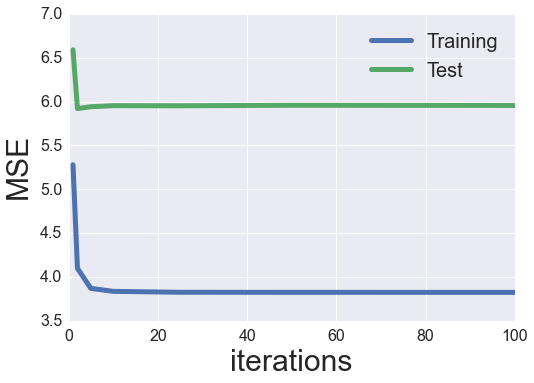

In [8]:
plot_learning_curve(iter_array, MF_ALS)

### Evaluation and Tuning

Looks like we have a reasonable amount of overfitting (our test MSE is ~ 50% greater than our training MSE). Also, the test MSE bottoms out around 5 iterations then actually increases after that (even more overfitting). We can try adding some regularization to see if this helps to alleviate some of the overfitting.

In [9]:
MF_ALS = ExplicitMF(train, n_factors=40, \
                    user_reg=30., item_reg=30.)

iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)

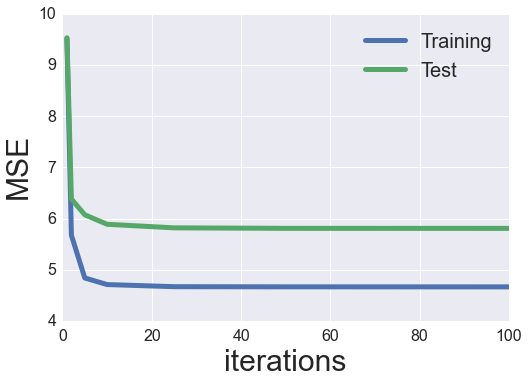

In [10]:
plot_learning_curve(iter_array, MF_ALS)

Hmmm, the regularization narrowed the gap between our training and test MSE, but it did not decrease the test MSE too much. We could spend all day searching for optimal hyperparameters. We'll just setup a small grid search and tune both the regularization terms and number of latent factors. The item and user regularization terms will be restricted to be equal to each other.

In [11]:
latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.1, 1., 10., 100.]
regularizations.sort()
iter_array = [1, 2, 5, 10, 25, 50, 100]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print 'Factors: {}'.format(fact)
    for reg in regularizations:
        print 'Regularization: {}'.format(reg)
        MF_ALS = ExplicitMF(train, n_factors=fact, \
                            user_reg=reg, item_reg=reg)
        MF_ALS.calculate_learning_curve(iter_array, test)
        min_idx = np.argmin(MF_ALS.test_mse)
        if MF_ALS.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_ALS.train_mse[min_idx]
            best_params['test_mse'] = MF_ALS.test_mse[min_idx]
            best_params['model'] = MF_ALS
            print 'New optimal hyperparameters'
            print pd.Series(best_params)

Factors: 5
Regularization: 0.1
New optimal hyperparameters
model        <__main__.ExplicitMF instance at 0x7fa54319ad88>
n_factors                                                   5
n_iter                                                     10
reg                                                       0.1
test_mse                                             5.549868
train_mse                                            6.034502
dtype: object
Regularization: 1.0
Regularization: 10.0
Regularization: 100.0
Factors: 10
Regularization: 0.1
New optimal hyperparameters
model        <__main__.ExplicitMF instance at 0x7fa542fc5a70>
n_factors                                                  10
n_iter                                                    100
reg                                                       0.1
test_mse                                             5.044188
train_mse                                             5.28118
dtype: object
Regularization: 1.0
Regularization: 10.0
Regul

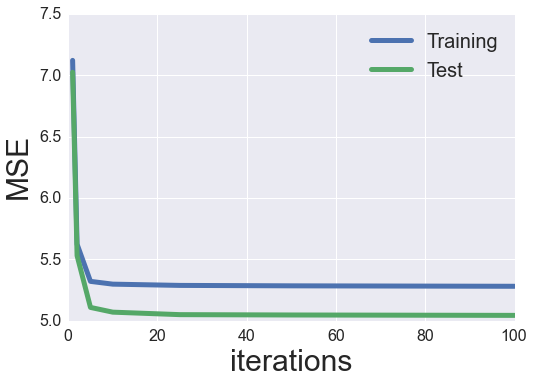

In [12]:
best_als_model = best_params['model']
plot_learning_curve(iter_array, best_als_model)

So it looks like the best performing parameters were 10 factors and a regularization value of 0.1. It creeps me out a bit that the test set error is actually *lower* than the training error, but so be it. I would like to again look at the movie-to-movie similarity like my previous [post]({filename}/2015-11-02-intro-to-collaborative-filtering.md), but let's first explore the other minimization algorithm: stochastic gradient descent (SGD).

## Stochastic Gradient Descent

With SGD, we again take derivatives of the loss function, but we take the derivative with respect to each variable in the model. The "stochastic" aspect of the algorithm involves taking the derivative and updating feature weights one individual sample at a time. So, for each sample, we take the derivative of each variable, set them all equal to zero, solve for the feature weights, and update each feature. Somehow this method actually converges.

We will use a similar loss function to before, but I am going to add some more details to the model. Instead of assuming that a user *u*'s rating for item *i* can be described simply by the dot product of the user and item latent vectors, we will consider that each user and item can have a bias term associated with them. The rational is that certan users might tend to rate all movies highly, or certain movies may tend to always have low ratings. The way that I think about it is that the bias term takes care of the "DC" part of the signal which allows the latent factors to account for the more detailed variance in signal (kind of like the AC part). We will also include a global bias term as well. With all things combined, our predicted rating becomes 

$$ \hat r_{ui} = \mu + b_{u} + b_{i} + \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i} $$

where $\mu$ is the global bias, and $b_{u}$ ($b_{i}$) is the user (item) bias. Our loss function now becomes

$$L = \sum\limits_{u,i}(r_{ui} - (\mu + b_{u} + b_{i} + \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i}))^{2} + 
\lambda_{xb} \sum\limits_{u} \left\Vert b_{u} \right\Vert^{2} + \lambda_{yb} \sum\limits_{i} \left\Vert b_{i} \right\Vert^{2} + \lambda_{xf} \sum\limits_{u} \left\Vert \textbf{x}_{u} \right\Vert^{2} + \lambda_{yf} \sum\limits_{u} \left\Vert \textbf{y}_{i} \right\Vert^{2}$$

where we have added on extra bias regularization terms. We want to update each feature (user and item latent factors and bias terms) with each sample. The update for the user bias is given by 

$$ b_{u} \leftarrow b_{u} - \eta \frac{\partial L}{\partial b_{u}} $$

where $\eta$ is the *learning rate* which weights how much our update modifies the feature weights. The derivative term is given by

$$ \frac{\partial L}{\partial b_{u}} = 2(r_{ui} - (\mu + b_{u} + b_{i} + \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i}))(-1) + 2\lambda_{xb} b_{u} $$
$$ \frac{\partial L}{\partial b_{u}} = 2(e_{ui})(-1) + 2\lambda_{xb} b_{u} $$
$$ \frac{\partial L}{\partial b_{u}} = - e_{ui} + \lambda_{xb} b_{u} $$

where $e_{ui}$ represents the error in our prediction, and we have dropped the factor of 2 (we can assume it gets rolled up in the learning rate). For all of our features, the updates end up being

$$ b_{u} \leftarrow b_{u} + \eta \, (e_{ui} - \lambda_{xb} b_{u}) $$
$$ b_{i} \leftarrow b_{i} + \eta \, (e_{ui} - \lambda_{yb} b_{i}) $$
$$ \textbf{x}_{u} \leftarrow \textbf{x}_{u} + \eta \, (e_{ui}\textbf{y}_{i} - \lambda_{xf} \textbf{x}_{u}) $$
$$ \textbf{y}_{i} \leftarrow \textbf{y}_{i} + \eta \, (e_{ui}\textbf{x}_{u} - \lambda_{yf} \textbf{y}_{i}) $$

### Computation

I've modified the original ```ExplicitMF``` class to allow for either ```sgd``` or ```als``` learning.

In [13]:
class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in xrange(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in xrange(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print '\tcurrent iteration: {}'.format(ctr)
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in xrange(self.user_vecs.shape[0]):
            for i in xrange(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print 'Iteration: {}'.format(n_iter)
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print 'Train mse: ' + str(self.train_mse[-1])
                print 'Test mse: ' + str(self.test_mse[-1])
            iter_diff = n_iter

Similar to the ALS section above, let's try looking at the learning curve for 40 latent factors, no regularizaton, and a learning rate of 0.001.

In [14]:
MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
Train mse: 1.1419376708
Test mse: 1.07081066329
Iteration: 2
Train mse: 1.07186223696
Test mse: 1.00654383987
Iteration: 5
Train mse: 0.975972057215
Test mse: 0.926091276051
Iteration: 10
Train mse: 0.919170129465
Test mse: 0.88774317347
Iteration: 25
	current iteration: 10
Train mse: 0.868550680386
Test mse: 0.861884799308
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.842385086053
Test mse: 0.850655185536
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.754656479746
Test mse: 0.815088950389
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.401505016743
Test mse: 0.841190046871


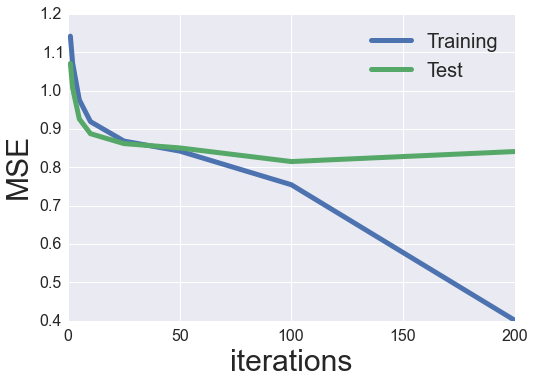

In [15]:
plot_learning_curve(iter_array, MF_SGD)

Wow, quite a bit better than before! I assume that this is likely due to the inclusion of bias terms (especially because the ratings are not normalized). 

### Evaluation and tuning

Let's try to optimize some hyperparameters. We'll start with a grid search of the learning rate.

In [16]:
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]

best_params = {}
best_params['learning_rate'] = None
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None


for rate in learning_rates:
    print 'Rate: {}'.format(rate)
    MF_SGD = ExplicitMF(train, n_factors=40, learning='sgd')
    MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=rate)
    min_idx = np.argmin(MF_SGD.test_mse)
    if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
        best_params['n_iter'] = iter_array[min_idx]
        best_params['learning_rate'] = rate
        best_params['train_mse'] = MF_SGD.train_mse[min_idx]
        best_params['test_mse'] = MF_SGD.test_mse[min_idx]
        best_params['model'] = MF_SGD
        print 'New optimal hyperparameters'
        print pd.Series(best_params)

Rate: 1e-05
New optimal hyperparameters
learning_rate                                               1e-05
model            <__main__.ExplicitMF instance at 0x7fa542e4b5f0>
n_iter                                                        200
test_mse                                                 1.006278
train_mse                                                1.071964
dtype: object
Rate: 0.0001
New optimal hyperparameters
learning_rate                                              0.0001
model            <__main__.ExplicitMF instance at 0x7fa542e67950>
n_iter                                                        200
test_mse                                                0.8663474
train_mse                                               0.8787174
dtype: object
Rate: 0.001
New optimal hyperparameters
learning_rate                                               0.001
model            <__main__.ExplicitMF instance at 0x7fa542e67908>
n_iter                                                     

Looks like a learning rate 0.001 was the best value. Note that the best test error was for only 100 iterations, not 200 - it's likely that the model started to overfit after this point. On that note, we'll now complete the hyperparameter optimization with a grid search through regularization terms and latent factors. This takes a while and could easily be parallelized, but that's beyond the scope of this post. Maybe next post I'll look into optimizing some of these algorithms.

In [17]:
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.001, 0.01, 0.1, 1.]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print 'Factors: {}'.format(fact)
    for reg in regularizations:
        print 'Regularization: {}'.format(reg)
        MF_SGD = ExplicitMF(train, n_factors=fact, learning='sgd',\
                            user_fact_reg=reg, item_fact_reg=reg, \
                            user_bias_reg=reg, item_bias_reg=reg)
        MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)
        min_idx = np.argmin(MF_SGD.test_mse)
        if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_SGD.train_mse[min_idx]
            best_params['test_mse'] = MF_SGD.test_mse[min_idx]
            best_params['model'] = MF_SGD
            print 'New optimal hyperparameters'
            print pd.Series(best_params)

Factors: 5
Regularization: 0.001
New optimal hyperparameters
model        <__main__.ExplicitMF instance at 0x7fa542e676c8>
n_factors                                                   5
n_iter                                                    200
reg                                                     0.001
test_mse                                            0.8545089
train_mse                                           0.6744243
dtype: object
Regularization: 0.01
New optimal hyperparameters
model        <__main__.ExplicitMF instance at 0x7fa542fc5830>
n_factors                                                   5
n_iter                                                    200
reg                                                      0.01
test_mse                                            0.8027033
train_mse                                           0.6791589
dtype: object
Regularization: 0.1
Regularization: 1.0
Factors: 10
Regularization: 0.001
Regularization: 0.01
Regularization: 0.1
Reg

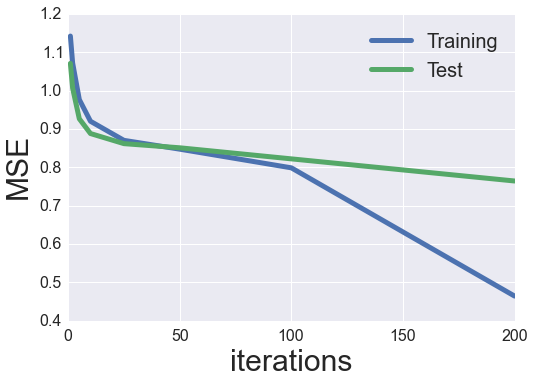

In [18]:
plot_learning_curve(iter_array, best_params['model'])

In [19]:
print 'Best regularization: {}'.format(best_params['reg'])
print 'Best latent factors: {}'.format(best_params['n_factors'])
print 'Best iterations: {}'.format(best_params['n_iter'])

Best regularization: 0.01
Best latent factors: 80
Best iterations: 200


It should be noted that both our best latent factors and best iteration count were at the maximums of their respective grid searches. In hindsight, we should have set the grid search to a wider range. In practice, I am going to just go with these parameters. We could spend all day optimizing, but this is just a blog post on extensively studied data.

## Eye tests

To wrap up this post, let's again look at movie-to-movie similarity using by using [themoviedb.org](http://www.themoviedb.org)'s API to grab the movie posters and visualize the top 5 most similar movies to an input movie. We'll use the cosine similarity of the item latent vectors to calculate the similarity. Let's go for gold and use the entire dataset to train the latent vectors and calculate similarity. We'll do this for both ALS and SGD models and compare the results.

We start by training both models with the best parameters we found.

In [20]:
best_als_model = ExplicitMF(ratings, n_factors=10, learning='als', \
                            item_fact_reg=0.1, user_fact_reg=0.1)
best_als_model.train(100)

In [21]:
best_sgd_model = ExplicitMF(ratings, n_factors=80, learning='sgd', \
                            item_fact_reg=0.01, user_fact_reg=0.01, \
                            user_bias_reg=0.01, item_bias_reg=0.01)
best_sgd_model.train(200, learning_rate=0.001)

I'll use this small function to calculate both the ALS and the SGD movie-to-movie similarity matrices.

In [22]:
def cosine_similarity(model):
    sim = model.item_vecs.dot(model.item_vecs.T)
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T

als_sim = cosine_similarity(best_als_model)
sgd_sim = cosine_similarity(best_sgd_model)

Lastly, just like before, let's read in the movie's IMDB urls and use those to query the themoviedb.org API.

In [23]:
# Load in movie data
idx_to_movie = {}
with open('u.item', 'r') as f:
    for line in f.readlines():
        info = line.split('|')
        idx_to_movie[int(info[0])-1] = info[4]

In [31]:
# Build function to query themoviedb.org's API
import requests
import json

# Get base url filepath structure. w185 corresponds to size of movie poster.
api_key = 'INSERT API KEY HERE'
headers = {'Accept': 'application/json'}
payload = {'api_key': api_key} 
response = requests.get("http://api.themoviedb.org/3/configuration",\
                        params=payload,\
                        headers=headers)
response = json.loads(response.text)
base_url = response['images']['base_url'] + 'w185'

def get_poster(imdb_url, base_url, api_key):
    # Get IMDB movie ID
    response = requests.get(imdb_url)
    movie_id = response.url.split('/')[-2]
    
    # Query themoviedb.org API for movie poster path.
    movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
    headers = {'Accept': 'application/json'}
    payload = {'api_key': api_key} 
    response = requests.get(movie_url, params=payload, headers=headers)
    try:
        file_path = json.loads(response.text)['posters'][0]['file_path']
    except:
        # IMDB movie ID is sometimes no good. Need to get correct one.
        movie_title = imdb_url.split('?')[-1].split('(')[0]
        payload['query'] = movie_title
        response = requests.get('http://api.themoviedb.org/3/search/movie',\
                                params=payload,\
                                headers=headers)
        try:
            movie_id = json.loads(response.text)['results'][0]['id']
            payload.pop('query', None)
            movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'\
                        .format(movie_id)
            response = requests.get(movie_url, params=payload, headers=headers)
            file_path = json.loads(response.text)['posters'][0]['file_path']
        except:
            # Sometimes the url just doesn't work.
            # Return '' so that it does not mess up Image()
            return ''
        
    return base_url + file_path

To visualize the posters in the Jupyter notebook's cells, we can use the IPython.display method. I've modified things slightly from last time so that the movie posters appear horizontally. Special thanks to [this](http://stackoverflow.com/a/27795087) Stack Overflow answer for the idea to use straight HTML.

In [32]:
from IPython.display import HTML
from IPython.display import display

def display_top_k_movies(similarity, mapper, movie_idx, base_url, api_key, k=5):
    movie_indices = np.argsort(similarity[movie_idx,:])[::-1]
    images = ''
    k_ctr = 0
    # Start i at 1 to not grab the input movie
    i = 1
    while k_ctr < 5:
        movie = mapper[movie_indices[i]]
        poster = get_poster(movie, base_url, api_key)
        if poster != '':
            images += "<img style='width: 120px; margin: 0px; \
                      float: left; border: 1px solid black;' src='%s' />"\
                      % poster
            k_ctr += 1
        i += 1
    display(HTML(images))

def compare_recs(als_similarity, sgd_similarity, mapper,\
                 movie_idx, base_url, api_key, k=5):
    # Display input
    display(HTML('<font size=5>'+'Input'+'</font>'))
    input_poster = get_poster(mapper[movie_idx], base_url, api_key)
    input_image = "<img style='width: 120px; margin: 0px; \
                      float: left; border: 1px solid black;' src='%s' />" \
                  % input_poster
    display(HTML(input_image))
    # Display ALS Recs
    display(HTML('<font size=5>'+'ALS Recs'+'</font>'))
    display_top_k_movies(als_similarity, idx_to_movie,\
                         movie_idx, base_url, api_key)
    # Display SGD Recs
    display(HTML('<font size=5>'+'SGD Recs'+'</font>'))
    display_top_k_movies(sgd_similarity, idx_to_movie,\
                         movie_idx, base_url, api_key)

I'll let you look through 5 different movie-to-movie recommendations below.

In [33]:
idx = 0 # Toy Story
compare_recs(als_sim, sgd_sim, idx_to_movie, idx, base_url, api_key)

In [34]:
idx = 1 # Golden Eye
compare_recs(als_sim, sgd_sim, idx_to_movie, idx, base_url, api_key)

In [35]:
idx = 20 # Muppet Treasure Island
compare_recs(als_sim, sgd_sim, idx_to_movie, idx, base_url, api_key)

In [36]:
idx = 40 # Billy Madison
compare_recs(als_sim, sgd_sim, idx_to_movie, idx, base_url, api_key)

In [37]:
idx = 500 # Dumbo
compare_recs(als_sim, sgd_sim, idx_to_movie, idx, base_url, api_key)

So how do we think we did? I find it very interesting that the best test MSE for our ALS model was 5.04 compared to 0.76 for SGD. That's a giant difference, and yet I thought the ALS recommendations might actually nudge out SGD; particularly, Golden Eye and Dumbo recommendations.

I have found similar behavior in some of my own work, as well. I have a vague hunch that SGD tends to overfit more than ALS and is more susceptible to popularity bias. Unfortunately, I have zero math to back this up, so it'll remain purely anecdotal for now. An alternative explanation could be that the SGD movie-to-movie recommendations are actually better than the ALS ones even if they seem like less similar movies. In a recent Netflix [paper](http://dl.acm.org/citation.cfm?id=2843948), they show a similar comparison of two different models' movie-to-movie recommendations. It turns out that the model with movies that look less similar by eye (but are generally more popular movies) performs better on A/B tests. And really, A/B tests are a much better way of truly benchmarking recommendation systems compared to this offline data modeling.

And on a final note, maybe we would want to just combine both models into an ensemble which seems to be what [everbody does](https://medium.com/@xamat/10-more-lessons-learned-from-building-real-life-ml-systems-part-i-b309cafc7b5e) nowadays.

*[Link](https://github.com/EthanRosenthal/DataPiques_source/blob/master/content/notebooks/2016-01-09-explicit-matrix-factorization-als-sgd.ipynb) to Jupyter notebook of this post.*